In [ ]:
!pip install --q opendatasets
!pip install "modin[all]"
!pip install -U "ray[default]"

In [5]:
import modin.pandas as mpd
import pandas as pd
import numpy as np
import os
import time
import dask.dataframe as dd
import ray
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import opendatasets as od
import csv

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import our dataset straight from kaggle
od.download('https://www.kaggle.com/datasets/michaelmcray/divvy-cyclist-04-20-to-04-21/download?datasetVersionNumber=1')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kostas696
Your Kaggle Key: ··········


100%|██████████| 157M/157M [00:02<00:00, 65.4MB/s]


## 1. Read the CSV file using Pandas

In [11]:
# Start time for Pandas
start_pandas = time.time()

# Read the CSV file using Pandas
df = pd.read_csv('/content/divvy-cyclist-04-20-to-04-21/Divvy_Cyclist.csv', low_memory=False)

# End time for Pandas
end_pandas = time.time()
time_pandas = end_pandas - start_pandas
print("Time taken by Pandas:", round(time_pandas, 2), "seconds")

Time taken by Pandas: 28.06 seconds


In [27]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86,Lincoln Ave & Diversey Pkwy,152.0,41.8964,-87.6610,41.9322,-87.6586,member
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503,Kosciuszko Park,499.0,41.9244,-87.7154,41.9306,-87.7238,member
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142,Indiana Ave & Roosevelt Rd,255.0,41.8945,-87.6179,41.8679,-87.6230,member
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216,Wood St & Augusta Blvd,657.0,41.9030,-87.6975,41.8992,-87.6722,member
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125,Sheridan Rd & Lawrence Ave,323.0,41.8902,-87.6262,41.9695,-87.6547,casual


In [28]:
df.shape

(3826978, 13)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3826978 entries, 0 to 3826977
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 379.6+ MB


## 2. Read the CSV file using Dask

In [18]:
# Start time for Dask
start_dask = time.time()

# Read the CSV file using Dask
ddf = dd.read_csv('/content/divvy-cyclist-04-20-to-04-21/Divvy_Cyclist.csv')

# End time for Dask
end_dask = time.time()
time_dask = end_dask - start_dask
print("Time taken by Dask:", round(time_dask, 2), "seconds")

Time taken by Dask: 0.04 seconds


## 3. Read the CSV file using Modin

In [13]:
# Start time for Modin
start_modin = time.time()

# Read the CSV file using Modin
mdf = mpd.read_csv('/content/divvy-cyclist-04-20-to-04-21/Divvy_Cyclist.csv')

# End time for Modin
end_modin = time.time()
time_modin = end_modin - start_modin
print("Time taken by Modin:", round(time_modin, 2), "seconds")

2024-03-10 13:41:37,693	INFO worker.py:1724 -- Started a local Ray instance.


Time taken by Modin: 39.48 seconds


## 4. Read the CSV file using Ray

In [14]:
# Start time for Ray
ray.shutdown()
ray.init()
start_ray = time.time()

# Read the CSV file using Ray
df_ray = ray.data.read_csv('/content/divvy-cyclist-04-20-to-04-21/Divvy_Cyclist.csv')

# End time for Ray
end_ray = time.time()
time_ray = end_ray - start_ray
print("Time taken by Ray:", round(time_ray, 2), "seconds")

2024-03-10 13:42:17,360	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Time taken by Ray: 6.52 seconds


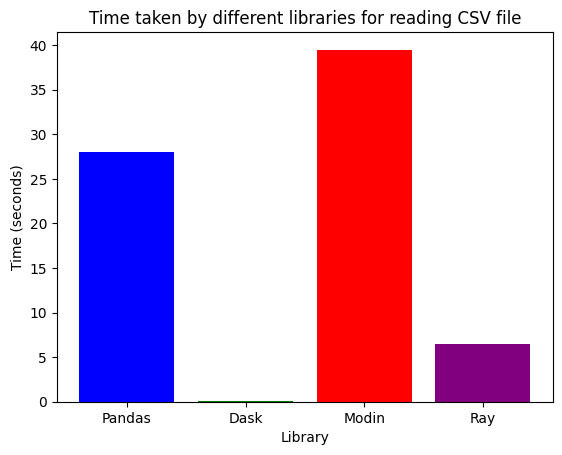

In [16]:
# Plotting
labels = ['Pandas', 'Dask', 'Modin', 'Ray']
times = [time_pandas, time_dask, time_modin, time_ray]

plt.bar(labels, times, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Library')
plt.ylabel('Time (seconds)')
plt.title('Time taken by different libraries for reading CSV file')
plt.show()

There's a significant difference in the times taken by each method. Dask appears to be the fastest, followed by Ray, while Pandas and Modin are slower. Unlike the rest, Dask is designed to efficiently handle large datasets that don't fit into memory by dividing them into smaller partitions or chunks. It's particularly well-suited for parallel and distributed computing.

Another way to import datasets is with csv.DictReader. As we can see below, it is by far the fastest, but it imports everything as strings, while the other methods try to guess the data types of each column separately and possibly do multiple other validations upon import. So, using csv.DictReader will possibly lead to a number of transformations on it before analyzing the contents.

In [51]:
start_dictreader = time.time()
drd = csv.DictReader(open('/content/divvy-cyclist-04-20-to-04-21/Divvy_Cyclist.csv'))

# End time for DictReader
end_dictreader = time.time()
time_dictreader = end_dictreader - start_dictreader
print("Time taken by Dictreader:", round(time_dictreader, 2), "seconds")

Time taken by Dictreader: 0.0 seconds


## Write a utility.py file

In [52]:
%%writefile utility.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime
import gc
import re

def read_config_file(filepath):
    with open(filepath, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)


def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string

def col_header_val(df,table_config):
    '''
    replace whitespaces in the column
    and standardized column names
    '''
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace('[^\w]','_',regex=True)
    df.columns = list(map(lambda x: x.strip('_'), list(df.columns)))
    df.columns = list(map(lambda x: replacer(x,'_'), list(df.columns)))
    expected_col = list(map(lambda x: x.lower(),  table_config['columns']))
    expected_col.sort()
    df.columns =list(map(lambda x: x.lower(), list(df.columns)))
    df = df.reindex(sorted(df.columns), axis=1)
    if len(df.columns) == len(expected_col) and list(expected_col)  == list(df.columns):
        print("column name and column length validation passed")
        return 1
    else:
        print("column name and column length validation failed")
        mismatched_columns_file = list(set(df.columns).difference(expected_col))
        print("Following File columns are not in the YAML file",mismatched_columns_file)
        missing_YAML_file = list(set(expected_col).difference(df.columns))
        print("Following YAML columns are not in the file uploaded",missing_YAML_file)
        logging.info(f'df columns: {df.columns}')
        logging.info(f'expected columns: {expected_col}')
        return 0

Writing utility.py


## Write a YAML file

In [53]:
%%writefile file.yaml
file_type: csv
dataset_name: Divvy_Cyclist
file_name: testfile
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
columns:
    - ride_id
    - rideable_type
    - started_at
    - ended_at
    - start_station_name
    - start_station_id
    - end_station_name
    - end_station_id
    - start_lat
    - start_lng
    - end_lat
    - end_lng
    - member_casual

Writing file.yaml


In [63]:
# Read config file
import utility as util
config_data = util.read_config_file("file.yaml")

In [55]:
config_data['inbound_delimiter']

','

In [56]:
# Inspect data of config file
config_data

{'file_type': 'csv',
 'dataset_name': 'Divvy_Cyclist',
 'file_name': 'testfile',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'columns': ['ride_id',
  'rideable_type',
  'started_at',
  'ended_at',
  'start_station_name',
  'start_station_id',
  'end_station_name',
  'end_station_id',
  'start_lat',
  'start_lng',
  'end_lat',
  'end_lng',
  'member_casual']}

In [57]:
# Read the file using config file
file_type = config_data['file_type']
source_file = "C:/Users/Amir/Desktop/" + config_data['file_name'] + f'.{file_type}'

## Validate number of columns and column names with YAML

In [58]:
# Validate the header of the file
util.col_header_val(df,config_data)

column name and column length validation passed


1

In [59]:
print("columns of files are:" ,df.columns)
print("columns of YAML are:" ,config_data['columns'])

columns of files are: Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')
columns of YAML are: ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


In [60]:
if util.col_header_val(df,config_data)==0:
    print("validation failed")
else:
    print("col validation passed")

column name and column length validation passed
col validation passed


## Write the file in pipe separated text file (|) in gz format

In [61]:
# Write dataframe to pipe-separated text file in gz format
df.to_csv('output_file.txt.gz', sep='|', index=False, compression='gzip')

## Create a summary of the file

In [62]:
# Get file size
file_size = os.path.getsize('output_file.txt.gz')

# Summary
print("Summary")
print("----------------------------")
print("Total number of rows:", len(df))
print("Total number of columns:", len(df.columns))
print("File size:", file_size, "bytes")

Summary
----------------------------
Total number of rows: 3826978
Total number of columns: 13
File size: 159030475 bytes
